## MPAA rating prediction

In [4]:
import pandas as pd
import numpy as np
import warnings
import re
import pickle
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

Import dataset :: using the rotten tomatoes dataset

In [5]:
dataset_df = pd.read_csv( './rtt_dataset/all_movie.csv' )
dataset_df = dataset_df[['Title', 'Rating', 'Description']]
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.head(4)

,Title,Rating,Description
0,The Mummy: Tomb of the Dragon Emperor,PG-13,The Fast and the Furious director Rob Cohen co...
1,The Masked Saint,PG-13,The journey of a professional wrestler who bec...
2,Spy Hard,PG-13,"Dead pan Leslie Nielsen stars as Dick Steele, ..."
3,Der Baader Meinhof Komplex (The Baader Meinhof...,R,Director Uli Edel teams with screenwriter Bern...


In [6]:
# finding unique mpaa rating in the dataset
dataset_df['Rating'].unique()

array(['PG-13 ', 'PG-13', 'R ', 'NR', 'PG', 'G', 'PG ', 'R', 'G ', 'NR ',
       'NC17', 'NC17 '], dtype=object)

In [7]:
# clean mpaa ratings
mpaa_fix = {
    'PG-13 ' : 'PG-13',
    'R ' : 'R',
    'PG ': 'PG',
    'G ' : 'G',
    'NR ': 'NR',
    'NC17 ': 'NC17'
}
for i, rating in dataset_df['Rating'].iteritems():
    if rating in mpaa_fix.keys():
        fix_val = mpaa_fix.get(rating)
        dataset_df.iloc[i]['Rating'] = fix_val
dataset_df['Rating'].unique()

array(['PG-13', 'R', 'NR', 'PG', 'G', 'NC17'], dtype=object)

In [8]:
# Clean the movie description
def clean_description( text_str ):
    text = re.sub('[^a-zA-Z]',  ' ', text_str)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

for i, description in dataset_df['Description'].iteritems():
    dataset_df.iloc[i]['Description'] = clean_description( str(description) )

In [9]:
pickle.dump(dataset_df, open('./data/dataset_df_cleaned_n_sample_exceptNC17.pkl', 'wb'))

## Data Distribution

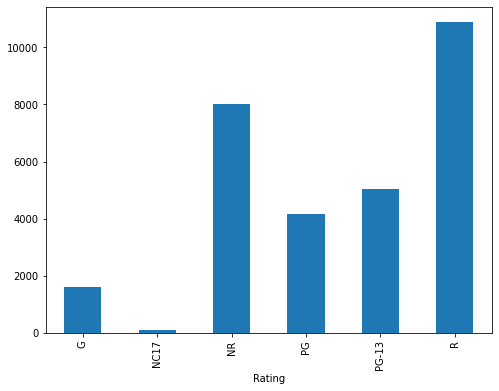

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

In [11]:
## drop G, NC-17
dataset_df = dataset_df[dataset_df.Rating != 'NC17']

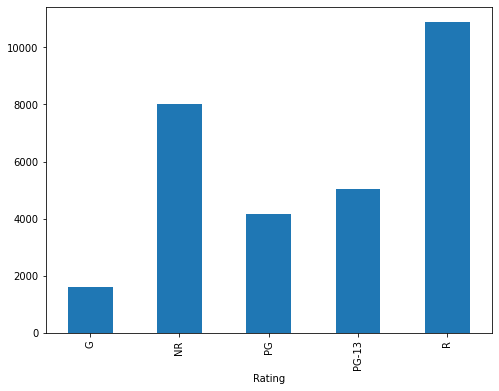

In [12]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

## Use same amount of labels

In [13]:
PG_count = dataset_df[dataset_df.Rating == 'G'].shape
PG_count

(1606, 3)

In [14]:
dataset_df = dataset_df.sample(frac=1).groupby('Rating').head(1606)
dataset_df

,Title,Rating,Description
7657,Mr. Destiny,PG-13,A dissatisfied businessman in the midst of mid...
22176,The Deep,PG,Peter Benchley who wrote Jaws also wrote The D...
6104,The Strawberry Blonde,NR,In this lyrical and picaresque evocation of tu...
4604,Winter in Wartime,R,Nazi occupied Holland In snow covered village ...
19212,The Quiet Earth,R,In tour de force sci fi story with only three ...
...,...,...,...
22501,Cats Don't Dance,G,A song and dance cat from Kokomo leads musical...
23313,Charlotte's Web,G,E White classic children story comes to the sc...
10796,The Country Bears,G,Like other celebrated rock and roll groups the...
22949,The Rescuers Down Under,G,The sequel to the Disney animated feature The ...


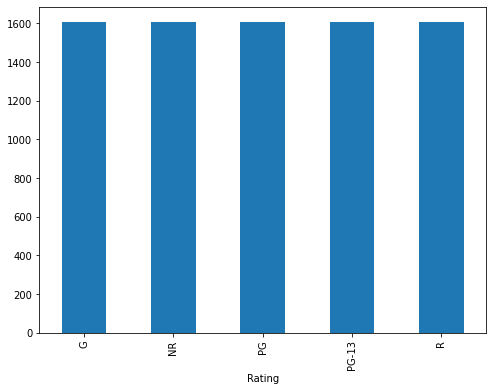

In [15]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

## Training model

In [16]:
training_df = pickle.load( open('./data/dataset_df_cleaned_n_sample_exceptNC17.pkl', 'rb') )

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D

In [18]:
_y = training_df['Rating']
encoder = LabelEncoder()
Y = encoder.fit_transform(_y)
Y

array([4, 4, 4, ..., 5, 4, 4])

In [19]:
X = training_df['Description']
X

0        The Fast and the Furious director Rob Cohen co...
1        The journey of professional wrestler who becom...
2        Dead pan Leslie Nielsen stars as Dick Steele a...
3        Director Uli Edel teams with screenwriter Bern...
4        One of cluster of late films about the Vietnam...
                               ...                        
29805    Filmed at least nine times over the last nine ...
29806    Fred MacMurray stars in this Walt Disney comed...
29807    A resident of rd century Earth becomes involve...
29808    Supernova chronicles the search and rescue pat...
29809    For years there have been documented cases of ...
Name: Description, Length: 29810, dtype: object

## Train, test split

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=40 )

In [21]:
Y_train = to_categorical(Y_train)
Y_test  = to_categorical(Y_test)

In [22]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [23]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [24]:
vocabulary_size = len(tokenizer.word_index) + 1
maxlen = 400 # Only concider first 400 words of each description

X_train = pad_sequences( X_train, maxlen=maxlen )
X_test  = pad_sequences( X_test, maxlen=maxlen )

## Use GloVe : Global Vectors for Word Representation
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [25]:
glove_file = open('./glove.6B/glove.6B.100d.txt', encoding='utf8')

In [26]:
embedd_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dims = np.asarray(records[1:], dtype='float32')
    embedd_dictionary[word] = vector_dims

glove_file.close()

In [27]:
embedd_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    embedd_vector = embedd_dictionary.get(word)
    if embedd_vector is not None:
        embedd_matrix[index] = embedd_vector

## Build the NN Model

In [28]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=100, weights=[embedd_matrix], trainable=False))
model.add(LSTM(units=256, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5635900   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
Total params: 6,003,010
Trainable params: 367,110
Non-trainable params: 5,635,900
_________________________________________________________________


In [29]:
hist = model.fit(X_train, Y_train, batch_size=128, epochs=34, validation_split=0.30, verbose=1)

Epoch 1/34
115/115 [==============================] - 107s 915ms/step - loss: 1.5017 - accuracy: 0.3441 - val_loss: 1.4087 - val_accuracy: 0.3937
Epoch 2/34
115/115 [==============================] - 106s 925ms/step - loss: 1.4156 - accuracy: 0.3914 - val_loss: 1.3575 - val_accuracy: 0.4066
Epoch 3/34
115/115 [==============================] - 105s 917ms/step - loss: 1.3534 - accuracy: 0.4222 - val_loss: 1.3343 - val_accuracy: 0.4292
Epoch 4/34
115/115 [==============================] - 104s 904ms/step - loss: 1.3125 - accuracy: 0.4355 - val_loss: 1.2560 - val_accuracy: 0.4696
Epoch 5/34
115/115 [==============================] - 105s 917ms/step - loss: 1.2654 - accuracy: 0.4722 - val_loss: 1.2195 - val_accuracy: 0.4895
Epoch 6/34
115/115 [==============================] - 107s 934ms/step - loss: 1.2233 - accuracy: 0.4924 - val_loss: 1.2481 - val_accuracy: 0.4688
Epoch 7/34
115/115 [==============================] - 106s 922ms/step - loss: 1.2174 - accuracy: 0.4975 - val_loss: 1.1854 -

In [30]:
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

280/280 [==============================] - 32s 113ms/step - loss: 0.9337 - accuracy: 0.7101
loss:  0.9337499141693115
accuracy:  0.7100525498390198


## Save model and tokenizer

In [31]:
# save model
model.save('./data/mpaa_classifier_n_sample_exceptNC17.h5')

# save word tokenizer
pickle.dump(tokenizer, open('./data/tokenizer_n_sample_exceptNC17.pkl', 'wb'))

## Metrics

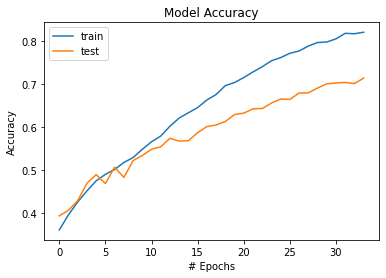

In [32]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

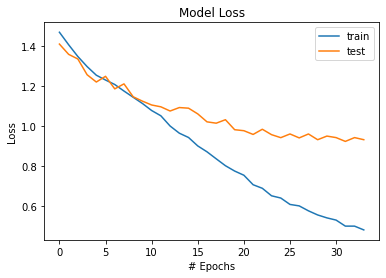

In [33]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

## Model Architecture

In [34]:
# load the saved model
from keras.models import load_model
model = load_model("./data/mpaa_classifier_n_sample_exceptNC17.h5")

In [35]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Demonstration